<h1>Open Haloscope</h1>
<h2>Simulation of the acquired data, of the expected signal and test of analysis techniques</h2>

The input signals coming from the two electron spin resonances are basically two sine waves. The axion field modulates the spins' resonance frequency, thereby producing a phase modulation on one of the tones, here we assume that the axion signal is entirely contained in one of the two sine waves.

<h3>Imports</h3>

In [1]:
import numpy as np

import matplotlib.pyplot as plt
# plot options
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=14)

from scipy.signal import periodogram, welch

In [2]:
# colors
c1 = '#AC84DF'
c2 = '#918764'
c2a = '#639147'

<h3>Useful functions</h3>

In [3]:
def dB(x):
    return 10 * np.log10(x)

In [4]:
# lock-in measurement
def lockin(t, signal, reference, tau=1e-3):
    mixed_signal = signal * reference
    
    n_out = int( np.max(t) / tau )
    points_in_tau = int( tau / (t[1] - t[0]) )
    output_signal = np.zeros((n_out))
    
    for i in range(n_out):
        n_start = i * points_in_tau
        n_end = (i+1) * points_in_tau
        output_signal[i] = np.sum( mixed_signal[n_start:n_end] )
        
    taus = tau * np.linspace(0, n_out, n_out)
    
    return taus, np.sqrt( output_signal )

<h3>Shaping the input signals</h3>

In [5]:
# creating time
t0 = 0 # s
t1 = 1e-2 # s
sampling_rate = 200e6 # Hz, sampling rate of the RedPitaya
nt = int( (t1 - t0) * sampling_rate )

t = np.linspace(t0, t1, nt)


# axion modulation
a0 = 1e-2 # axion amplitude
fa = 0.2e6 # axion mass
axion = a0 * np.sin(2*np.pi * fa * t)

# common modulation
c0 = 1e-2 # common noise amplitude
fc = 0.3e6 # common noise frequency
common_modulation = c0 * np.sin(2*np.pi * fc * t)

# input signal 1
f1 = 10e6 # Hz
a1 = 1
s1 = a1 * np.sin(2*np.pi * f1 * t + common_modulation)

# input signal 2
f2 = 11e6 # Hz
a2 = 1
s2 = a2 * np.sin(2*np.pi * f2 * t + axion + common_modulation)

In [6]:
# fourier transforms
fft_f = np.fft.fftfreq(t.shape[-1])

fft_s1 = np.fft.fft(s1)
fft_s2 = np.fft.fft(s2)

<h4>Visualising an amplified axion effect</h4>

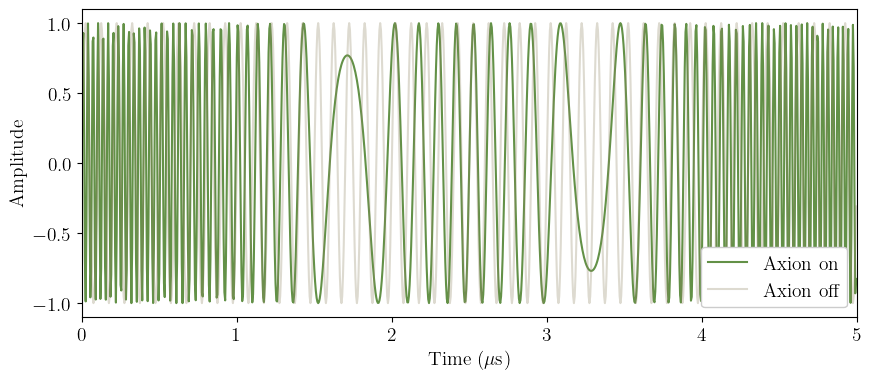

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
start = 0
stop = 1000
time_scale = 1e-6 # to microsecond

# amplifiy the effect of the axion signal
axion_amplification = 1e4
s2_amplified = a2 * np.sin(2*np.pi * f2 * t + axion_amplification*axion)

ax.plot( t[start:stop] / time_scale, s2_amplified[start:stop], label='Axion on', c=c2a )
ax.plot( t[start:stop] / time_scale, s1[start:stop], label='Axion off', c=c2, alpha=0.3 )
ax.set_xlim([0,5])

ax.set_xlabel('Time ($\mathrm{\mu s}$)')
ax.set_ylabel('Amplitude')
ax.legend(loc='lower right', framealpha=1)

<h4>Noise</h4>

In [8]:
# noise
relative_amplitude_noise = 1e-2
amplitude_noise = np.random.normal(scale = relative_amplitude_noise, size = nt)

relative_phase_noise = 1e-5
phase_noise = np.random.normal(scale = relative_phase_noise, size = nt)

# input signal 1 with noise
s1n = a1 * np.sin(2*np.pi * f1 * t + common_modulation + phase_noise) + amplitude_noise

# input signal 2 with noise
s2n = a2 * np.sin(2*np.pi * f2 * t + common_modulation + phase_noise + axion) + amplitude_noise

In [9]:
# fourier transforms
psd_s1n = periodogram(s1n, fs = sampling_rate)
psd_s2n = periodogram(s2n, fs = sampling_rate)

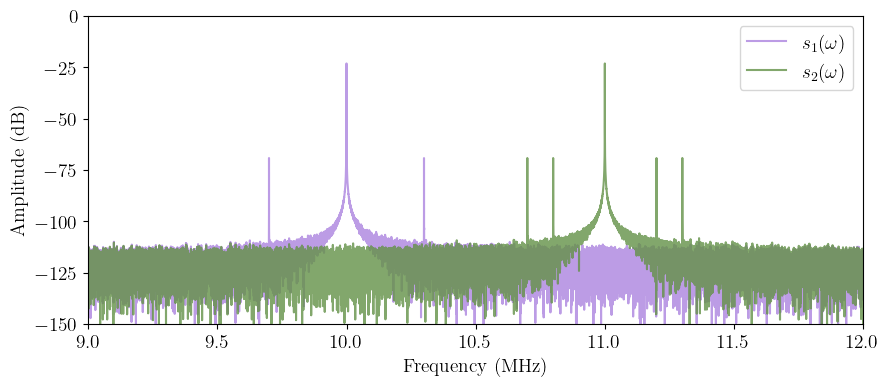

In [10]:
# plot the signals
fig, ax = plt.subplots(1, 1, figsize=(10,4))
frequency_scale = 1e6 # to MHz

ax.plot(psd_s1n[0] / frequency_scale, dB( psd_s1n[1] ), c=c1, alpha=0.8, label='$s_1(\omega)$')
ax.plot(psd_s2n[0] / frequency_scale, dB( psd_s2n[1] ), c=c2a, alpha=0.8, label='$s_2(\omega)$')
ax.set_xlim([9,12])
ax.set_ylim([-150, 0])

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Amplitude (dB)')
ax.legend()

<h3>Extracting the signal</h3>
This part takes the simulated data and analyses them, in order to optimise the extraction of the axionic signal.
It follows the procedure used for the sideband interferometer devised by N.C. et al. but implements the procedure digitally. Since the expected signal is a phase modulation, it is better to work in the common phase noise rejection configuration, where the down-conversion signal phase is $\delta=\pi$.

In [11]:
delta_amp_rejection = np.pi / 2.00
delta_phase_rejection  = np.pi/1.00

downconversion_frequency = (f1 + f2)/2
downconverted_frequency_origin = (f2 - f1)/2

downconversion_signal = np.sin( 2*np.pi * downconversion_frequency * t + delta_phase_rejection)

In [12]:
psd_s = periodogram((s1n + s2n) * downconversion_signal, fs = sampling_rate)
downconverted_frequency = psd_s[0] - downconverted_frequency_origin

Text(0, 0.5, 'Amplitude (dB)')

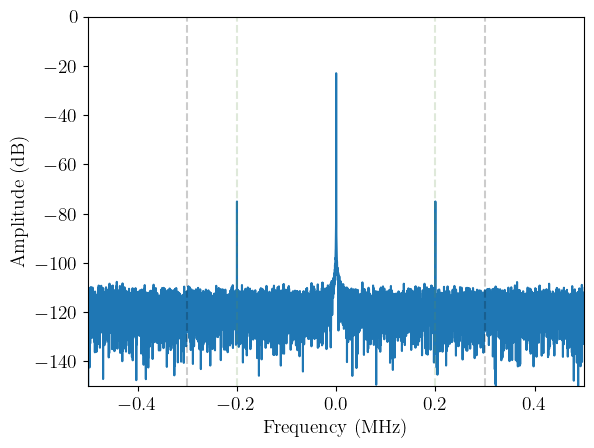

In [13]:
plt.plot(downconverted_frequency / frequency_scale, dB( psd_s[1] ))
plt.vlines(-fa / frequency_scale, -150, 0, linestyle = 'dashed', color = c2a, alpha=0.2)
plt.vlines(fa / frequency_scale, -150, 0, linestyle = 'dashed', color = c2a, alpha=0.2)

plt.vlines(-fc / frequency_scale, -150, 0, linestyle = 'dashed', color = 'black', alpha=0.2)
plt.vlines(fc / frequency_scale, -150, 0, linestyle = 'dashed', color = 'black', alpha=0.2)

plt.xlim([-0.5, 0.5])
plt.ylim([-150, 0])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (dB)')